## CENSUS INCOME PREDICTION 

In [84]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from sklearn.linear_model import LogisticRegression

In [2]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator , BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import numpy as np
import functools
from pyspark.ml.feature import OneHotEncoder

In [81]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error,  r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score

In [4]:
from pyspark import SparkContext
sc = SparkContext("local", "First App")

In [6]:
from pyspark.sql import HiveContext
hive_context = HiveContext(sc)
census = hive_context.table("adult_census")
census.show()

+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
| age|       workclass|fnlwgt|   education|education_num|    marital_status|       occupation|  relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
|null|       workclass|  null|   education|         null|    marital_status|       occupation|  relationship| race|   sex|        null|        null|          null|native_country|income|
|  22|         Private|148187|        11th|            7|     Never-married|    Other-service|Other-relative|White|  Male|           0|           0|            40| United-States| <=50K|
|  77|Self-emp-not-inc|138714|Some-college|           10|Married-civ-s

In [7]:
census.registerTempTable("census_temp")
hive_context.sql("select * from census_temp").show()

+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
| age|       workclass|fnlwgt|   education|education_num|    marital_status|       occupation|  relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
|null|       workclass|  null|   education|         null|    marital_status|       occupation|  relationship| race|   sex|        null|        null|          null|native_country|income|
|  22|         Private|148187|        11th|            7|     Never-married|    Other-service|Other-relative|White|  Male|           0|           0|            40| United-States| <=50K|
|  77|Self-emp-not-inc|138714|Some-college|           10|Married-civ-s

In [8]:
hive_context.sql("select race from census_temp").show()

+-----+
| race|
+-----+
| race|
|White|
|White|
|White|
|White|
|Black|
|White|
|Black|
|White|
|White|
|White|
|White|
|White|
|White|
|White|
|Black|
|Black|
|White|
|White|
|White|
+-----+
only showing top 20 rows



In [9]:
from pyspark.sql import SQLContext

In [10]:
sql_context=SQLContext(sc)

In [11]:
df = sql_context.sql("SELECT * FROM adult_census")

In [12]:
df.show()

+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
| age|       workclass|fnlwgt|   education|education_num|    marital_status|       occupation|  relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+----+----------------+------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+
|null|       workclass|  null|   education|         null|    marital_status|       occupation|  relationship| race|   sex|        null|        null|          null|native_country|income|
|  22|         Private|148187|        11th|            7|     Never-married|    Other-service|Other-relative|White|  Male|           0|           0|            40| United-States| <=50K|
|  77|Self-emp-not-inc|138714|Some-college|           10|Married-civ-s

In [13]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: integer (nullable = true)
 |-- capital_loss: integer (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [14]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|education|education_num|marital_status|occupation|relationship|race|sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|  1|        0|     1|        0|            1|             0|         0|           0|   0|  0|           1|           1|             1|             0|     0|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+



In [15]:
df = df.na.drop() 

In [16]:
for col in df.columns:
    print(col,df.select(col).distinct().count())

('age', 73)
('workclass', 9)
('fnlwgt', 21648)
('education', 16)
('education_num', 16)
('marital_status', 7)
('occupation', 15)
('relationship', 6)
('race', 5)
('sex', 2)
('capital_gain', 119)
('capital_loss', 92)
('hours_per_week', 94)
('native_country', 42)
('income', 2)


### CONVERTING TO PANDAS DF FOR VISUALIZATION

In [17]:
df2 = df.toPandas()

In [18]:
df2

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,22,Private,148187,11th,7,Never-married,Other-service,Other-relative,White,Male,0,0,40,United-States,<=50K
1,77,Self-emp-not-inc,138714,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K
2,47,?,224108,HS-grad,9,Widowed,?,Unmarried,White,Female,0,0,40,United-States,<=50K
3,23,Private,314894,HS-grad,9,Never-married,Exec-managerial,Own-child,White,Female,0,0,45,United-States,<=50K
4,46,Private,166181,Some-college,10,Never-married,Adm-clerical,Own-child,Black,Female,0,0,36,United-States,<=50K
5,29,State-gov,204516,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,15,United-States,<=50K
6,35,Private,407913,HS-grad,9,Separated,Other-service,Not-in-family,Black,Male,0,0,40,United-States,<=50K
7,28,Private,96219,Bachelors,13,Married-civ-spouse,Other-service,Wife,White,Female,0,0,15,United-States,<=50K
8,58,Self-emp-inc,78104,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,<=50K
9,19,?,252292,HS-grad,9,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K


/usr/local/anaconda/python2/lib/python2.7/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


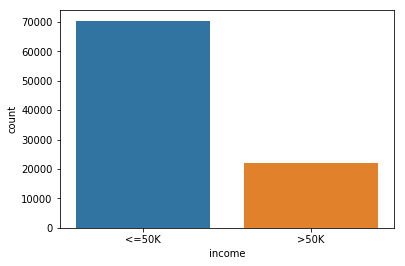

In [19]:
sn.countplot(df2['income'])
plt.show()

In [20]:
df2.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

/usr/local/anaconda/python2/lib/python2.7/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


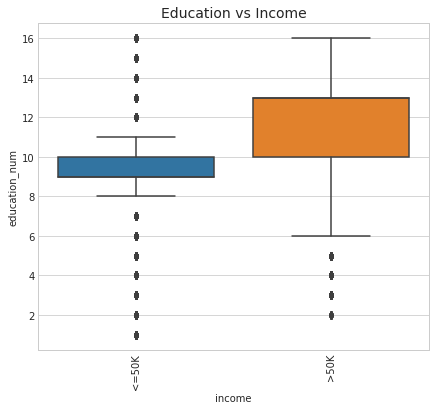

In [21]:
plt.figure(figsize=(7,6))
sn.set_style('whitegrid')
sn.boxplot(df2['income'],df2['education_num'])
plt.xticks(rotation=90)
plt.title('Education vs Income',fontsize=14)
plt.show()


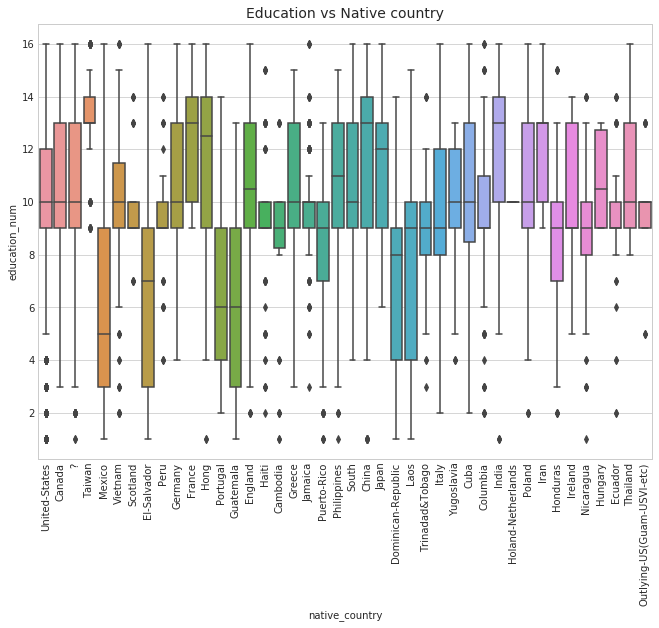

In [22]:
## DISTRIBUTION OF EDUCATION ACROSS DIFFERENT COMMUNITIES
plt.figure(figsize=(11,8))
sn.set_style('whitegrid')
sn.boxplot(df2['native_country'],df2['education_num'])
plt.xticks(rotation=90)
plt.title('Education vs Native country',fontsize=14)
plt.show()

## JAPAN, INDIA, FRANCE, HONGKONG AMONG HIGHEST EDUCATED IN USA
## MEDIAN OF THESE COUNTRIES HIGHER THAN US CITIZENS

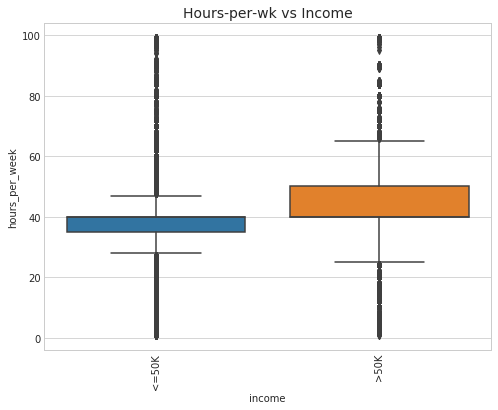

In [23]:
plt.figure(figsize=(8,6))
sn.set_style('whitegrid')
sn.boxplot(df2['income'],df2['hours_per_week'])
plt.xticks(rotation=90)
plt.title('Hours-per-wk vs Income',fontsize=14)
plt.show()

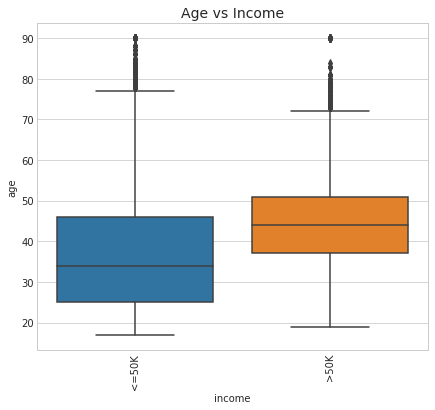

In [24]:
plt.figure(figsize=(7,6))
sn.set_style('whitegrid')
sn.boxplot(df2['income'],df2['age'])
plt.xticks(rotation=90)
plt.title('Age vs Income',fontsize=14)
plt.show()

### ANALYSING TRENDS FOR INCOME <=50K

In [25]:
df3 = df2[df2['income']=='<=50K']

In [26]:
df3

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,22,Private,148187,11th,7,Never-married,Other-service,Other-relative,White,Male,0,0,40,United-States,<=50K
1,77,Self-emp-not-inc,138714,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K
2,47,?,224108,HS-grad,9,Widowed,?,Unmarried,White,Female,0,0,40,United-States,<=50K
3,23,Private,314894,HS-grad,9,Never-married,Exec-managerial,Own-child,White,Female,0,0,45,United-States,<=50K
4,46,Private,166181,Some-college,10,Never-married,Adm-clerical,Own-child,Black,Female,0,0,36,United-States,<=50K
5,29,State-gov,204516,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,15,United-States,<=50K
6,35,Private,407913,HS-grad,9,Separated,Other-service,Not-in-family,Black,Male,0,0,40,United-States,<=50K
7,28,Private,96219,Bachelors,13,Married-civ-spouse,Other-service,Wife,White,Female,0,0,15,United-States,<=50K
8,58,Self-emp-inc,78104,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,<=50K
9,19,?,252292,HS-grad,9,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K


In [27]:
df4 = df3.groupby('race')[['income']].count()
df4

,income
race,
Amer-Indian-Eskimo,788
Asian-Pac-Islander,2147
Black,7819
Other,689
White,58965


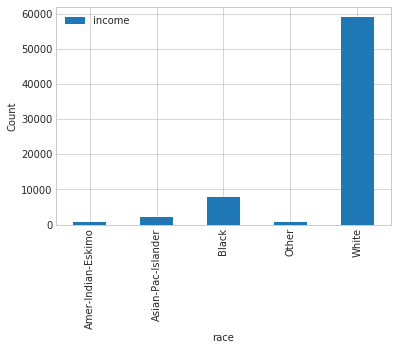

In [28]:
df4.plot.bar()
plt.ylabel('Count')
plt.show()

## WHITES FORM A MAJORITY OF POPULATION WITH INCOME LESS THAN 50K

In [29]:
df4 = df3.groupby(['race','sex'])[['income']].count().unstack()

In [30]:
df4

income       
sex                Female   Male
race                            
Amer-Indian-Eskimo    307    481
Asian-Pac-Islander    869   1278
Black                4174   3645
Other                 298    391
White               21672  37293

In [31]:
plt.style.available

[u'seaborn-darkgrid',
 u'Solarize_Light2',
 u'seaborn-notebook',
 u'classic',
 u'seaborn-ticks',
 u'grayscale',
 u'bmh',
 u'seaborn-talk',
 u'dark_background',
 u'ggplot',
 u'fivethirtyeight',
 u'_classic_test',
 u'seaborn-colorblind',
 u'seaborn-deep',
 u'seaborn-whitegrid',
 u'seaborn',
 u'seaborn-poster',
 u'seaborn-bright',
 u'seaborn-muted',
 u'seaborn-paper',
 u'seaborn-white',
 u'fast',
 u'seaborn-pastel',
 u'seaborn-dark',
 u'seaborn-dark-palette']

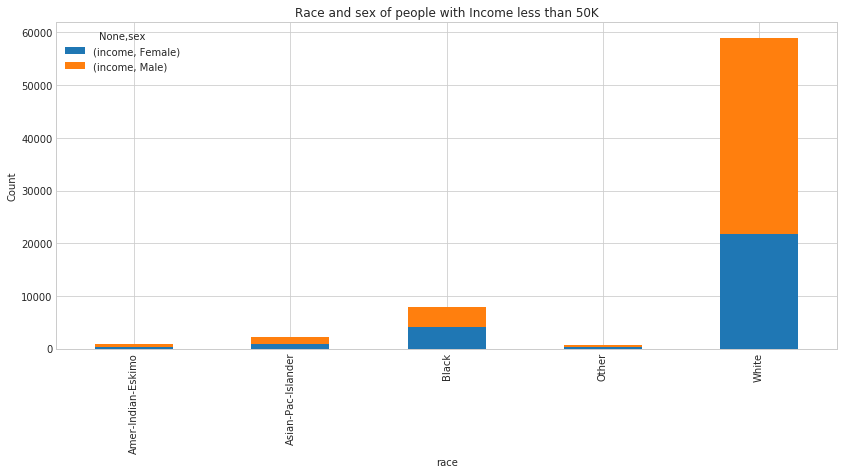

In [32]:
df4.plot(kind='bar',stacked='True',figsize=(14,6))
plt.title('Race and sex of people with Income less than 50K')
plt.style.use('Solarize_Light2')
plt.ylabel('Count')
plt.show()

## MAJORITY OF WHITE MALES 

In [33]:
df4 = df3.groupby(['race','marital_status'])[['income']].count().unstack()
df4

income                                       \
marital_status     Divorced Married-AF-spouse Married-civ-spouse   
race                                                               
Amer-Indian-Eskimo    153.0               NaN              264.0   
Asian-Pac-Islander    170.0               NaN              770.0   
Black                1210.0               NaN             1535.0   
Other                  72.0               NaN              235.0   
White                9491.0              37.0            20776.0   

                                                                          
marital_status     Married-spouse-absent Never-married Separated Widowed  
race                                                                      
Amer-Indian-Eskimo                  21.0         281.0      37.0    32.0  
Asian-Pac-Islander                 108.0        1009.0      36.0    54.0  
Black                              166.0        3777.0     762.0   369.0  
Other                               41.0         283.0      37.0    21.0  
White                              748.0       23865.0    1951.0  2097.0

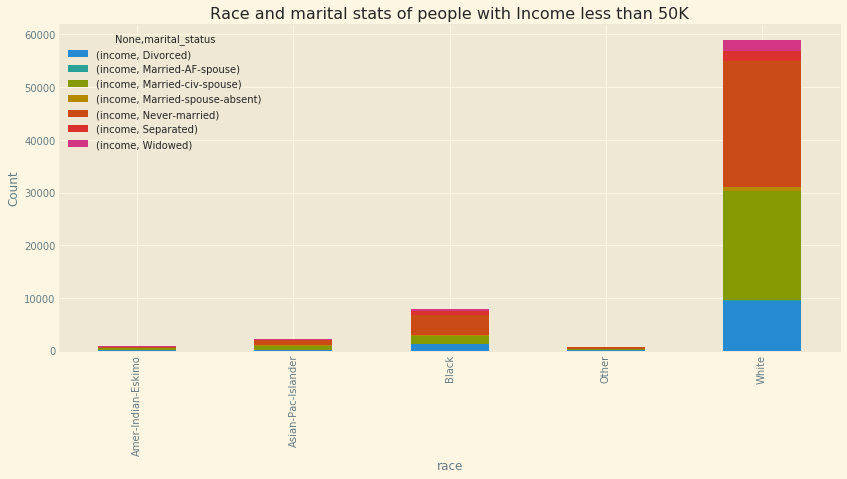

In [34]:
df4.plot(kind='bar',stacked='True',figsize=(14,6))
plt.title('Race and marital stats of people with Income less than 50K')
plt.style.use('Solarize_Light2')
plt.ylabel('Count')
plt.show()

## MAJORITY OF NEVER MARRIED OR MARRIED WITH SPOUSE ABSENT 

In [35]:
df4 = df3.groupby(['education','sex'])[['income']].count().unstack()
df4

income       
sex          Female   Male
education                 
10th            839   1605
11th           1203   2042
12th            390    757
1st-4th         138    337
5th-6th         230    671
7th-8th         447   1276
9th             369   1004
Assoc-acdm     1045   1179
Assoc-voc      1265   1678
Bachelors      3687   5279
Doctorate       108    186
HS-grad        8971  16193
Masters        1035   1137
Preschool        33    107
Prof-school     151    280
Some-college   7409   9357

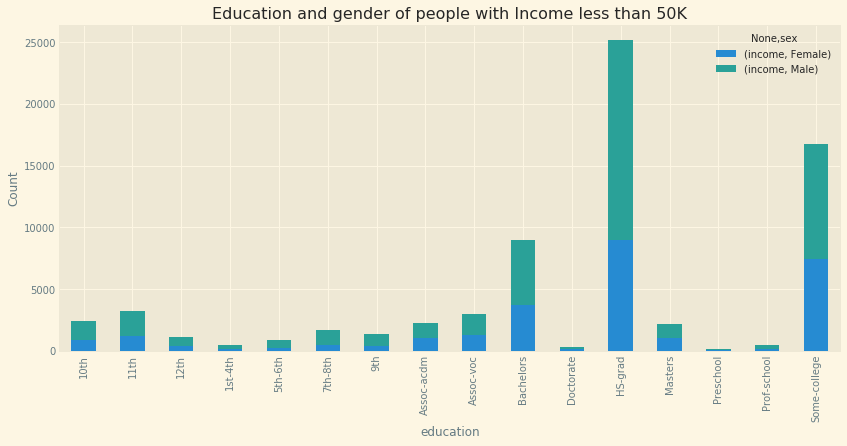

In [36]:
df4.plot(kind='bar',stacked='True',figsize=(14,6))
plt.title('Education and gender of people with Income less than 50K')
plt.style.use('Solarize_Light2')
plt.ylabel('Count')
plt.show()

In [37]:
df3['education'].value_counts()

HS-grad         25164
Some-college    16766
Bachelors        8966
11th             3245
Assoc-voc        2943
10th             2444
Assoc-acdm       2224
Masters          2172
7th-8th          1723
9th              1373
12th             1147
5th-6th           901
1st-4th           475
Prof-school       431
Doctorate         294
Preschool         140
Name: education, dtype: int64

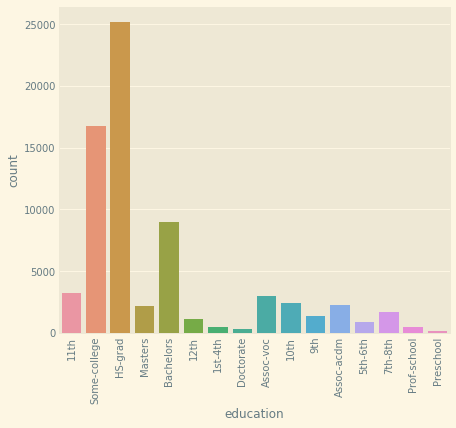

In [38]:
plt.figure(figsize=(7,6))
sn.countplot(df3['education'])
plt.xticks(rotation=90)
plt.show()

## MOSTLY HS GRAD OR SOME COLLEGE

In [39]:
df2['income'].dtypes

dtype('O')

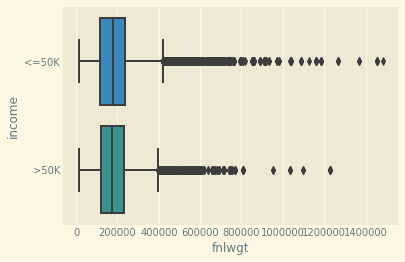

In [40]:
sn.boxplot(df2['fnlwgt'],df2['income'])
plt.show()

### NO EFFECT OF FNLWGT ON INCOME

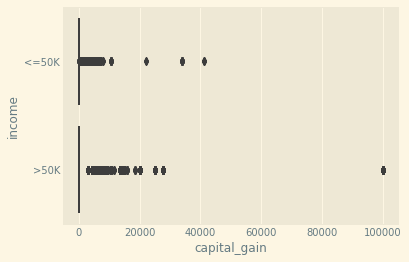

In [41]:
sn.boxplot(df2['capital_gain'],df2['income'])
plt.show()

In [42]:
df2 = df2[df2['capital_gain']<35000]

In [43]:
df2['capital_gain'].describe()

count    92126.000000
mean       582.248410
std       2525.800529
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      34095.000000
Name: capital_gain, dtype: float64

In [44]:
df2['capital_gain'].median()

0.0

### MODEL BUILDING

In [45]:
df2.columns

Index([u'age', u'workclass', u'fnlwgt', u'education', u'education_num',
       u'marital_status', u'occupation', u'relationship', u'race', u'sex',
       u'capital_gain', u'capital_loss', u'hours_per_week', u'native_country',
       u'income'],
      dtype='object')

In [53]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92126 entries, 0 to 92560
Data columns (total 15 columns):
age               92126 non-null int64
workclass         92126 non-null object
fnlwgt            92126 non-null int64
education         92126 non-null object
education_num     92126 non-null int64
marital_status    92126 non-null object
occupation        92126 non-null object
relationship      92126 non-null object
race              92126 non-null object
sex               92126 non-null object
capital_gain      92126 non-null int64
capital_loss      92126 non-null int64
hours_per_week    92126 non-null int64
native_country    92126 non-null object
income            92126 non-null object
dtypes: int64(6), object(9)
memory usage: 11.2+ MB


In [54]:
df2.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,22,Private,148187,11th,7,Never-married,Other-service,Other-relative,White,Male,0,0,40,United-States,<=50K
1,77,Self-emp-not-inc,138714,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K
2,47,?,224108,HS-grad,9,Widowed,?,Unmarried,White,Female,0,0,40,United-States,<=50K
3,23,Private,314894,HS-grad,9,Never-married,Exec-managerial,Own-child,White,Female,0,0,45,United-States,<=50K
4,46,Private,166181,Some-college,10,Never-married,Adm-clerical,Own-child,Black,Female,0,0,36,United-States,<=50K


In [55]:
df2 = df2.drop(columns=['native_country','education_num'],axis =1 )

### DUMMY VARIABLE CREATION

In [60]:
data_dummy = df2
def dummify_dataset(dataframe, col):
    dummy_column = pd.get_dummies(dataframe[col], prefix = col, drop_first = True)
    new_data = pd.concat([dataframe,dummy_column],axis = 1)
    new_data = new_data.drop([col], axis=1)
    return new_data

## CATEGORICAL VARIABLES 
dcol = ['workclass', 'education', 'marital_status', 'occupation', 'relationship','race','sex','income']
## PASSING THE MODIFIED DATASET IN EACH ITERATION
for i in range(0,7):
    data_dummy = dummify_dataset(data_dummy,dcol[i])

In [61]:
data_dummy.head()

,age,fnlwgt,capital_gain,capital_loss,hours_per_week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,22,148187,0,0,40,<=50K,0,0,0,1,...,0,1,0,0,0,0,0,0,1,1
1,77,138714,0,0,40,<=50K,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,47,224108,0,0,40,<=50K,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,23,314894,0,0,45,<=50K,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,46,166181,0,0,36,<=50K,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0


In [62]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [67]:
data_dummy['income'] = le.fit_transform(data_dummy['income'])

In [68]:
data_dummy['income'].value_counts()

0    70403
1    21723
Name: income, dtype: int64

In [69]:
data_dummy.head()

,age,fnlwgt,capital_gain,capital_loss,hours_per_week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,22,148187,0,0,40,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,1
1,77,138714,0,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,47,224108,0,0,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,23,314894,0,0,45,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,46,166181,0,0,36,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0


In [75]:
scaler = StandardScaler()
data_dummy[['age','fnlwgt','hours_per_week']] = scaler.fit_transform(data_dummy[['age','fnlwgt','hours_per_week']])
data_dummy

,age,fnlwgt,capital_gain,capital_loss,hours_per_week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,-1.209791,-0.390570,0,0,-0.031799,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,1
1,2.827215,-0.480081,0,0,-0.031799,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0.625212,0.326814,0,0,-0.031799,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,-1.136391,1.184658,0,0,0.374393,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,0.551811,-0.220543,0,0,-0.356753,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
5,-0.695990,0.141687,0,0,-2.062761,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,-0.255590,2.063602,0,0,-0.031799,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,1
7,-0.769391,-0.881620,0,0,-2.062761,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
8,1.432613,-1.052790,0,0,0.374393,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
9,-1.429992,0.593127,0,0,-0.031799,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1


In [76]:
data_dummy[['capital_gain','capital_loss']] = scaler.fit_transform(data_dummy[['capital_gain','capital_loss']])
data_dummy.head()

,age,fnlwgt,capital_gain,capital_loss,hours_per_week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,-1.209791,-0.390570,-0.230522,-0.218021,-0.031799,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,1
1,2.827215,-0.480081,-0.230522,-0.218021,-0.031799,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0.625212,0.326814,-0.230522,-0.218021,-0.031799,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,-1.136391,1.184658,-0.230522,-0.218021,0.374393,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
4,0.551811,-0.220543,-0.230522,-0.218021,-0.356753,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0


### FEATURE SELECTION

In [77]:
from sklearn.model_selection import train_test_split
X = data_dummy[data_dummy.columns.difference(['income'])]
Y = data_dummy['income']

In [78]:
X_train, X_test, Y_train,Y_test = train_test_split(X,Y,test_size = .30, random_state = 86)

In [85]:
logreg = LogisticRegression()
rfe = RFE(logreg, 20)             # running RFE with 13 variables as output
rfe = rfe.fit(X_train, Y_train)

In [86]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('age', False, 16),
 ('capital_gain', False, 3),
 ('capital_loss', False, 26),
 (u'education_11th', False, 38),
 (u'education_12th', False, 22),
 (u'education_1st-4th', True, 1),
 (u'education_5th-6th', False, 11),
 (u'education_7th-8th', False, 12),
 (u'education_9th', False, 13),
 (u'education_Assoc-acdm', True, 1),
 (u'education_Assoc-voc', True, 1),
 (u'education_Bachelors', True, 1),
 (u'education_Doctorate', True, 1),
 (u'education_HS-grad', False, 2),
 (u'education_Masters', True, 1),
 (u'education_Preschool', True, 1),
 (u'education_Prof-school', True, 1),
 (u'education_Some-college', True, 1),
 ('fnlwgt', False, 35),
 ('hours_per_week', False, 14),
 (u'marital_status_Married-AF-spouse', True, 1),
 (u'marital_status_Married-civ-spouse', True, 1),
 (u'marital_status_Married-spouse-absent', False, 32),
 (u'marital_status_Never-married', False, 4),
 (u'marital_status_Separated', False, 30),
 (u'marital_status_Widowed', False, 37),
 (u'occupation_Adm-clerical', False, 24),
 (u'occ

In [87]:
from pandas import DataFrame
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=X_train.columns)
Selected = Selected.reset_index()
Selected[Selected['RFE'] == True]

,index,RFE
5,education_1st-4th,True
9,education_Assoc-acdm,True
10,education_Assoc-voc,True
11,education_Bachelors,True
12,education_Doctorate,True
14,education_Masters,True
15,education_Preschool,True
16,education_Prof-school,True
17,education_Some-college,True
20,marital_status_Married-AF-spouse,True


In [89]:
col = X_train.columns[rfe.support_]

In [90]:
X_train.columns[~rfe.support_]

Index([                                 u'age',
                               u'capital_gain',
                               u'capital_loss',
                             u'education_11th',
                             u'education_12th',
                          u'education_5th-6th',
                          u'education_7th-8th',
                              u'education_9th',
                          u'education_HS-grad',
                                     u'fnlwgt',
                             u'hours_per_week',
       u'marital_status_Married-spouse-absent',
               u'marital_status_Never-married',
                   u'marital_status_Separated',
                     u'marital_status_Widowed',
                    u'occupation_Adm-clerical',
                    u'occupation_Armed-Forces',
                    u'occupation_Craft-repair',
                 u'occupation_Exec-managerial',
               u'occupation_Machine-op-inspct',
                  u'occupation_Prof-spec

### VIF 

In [94]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [96]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
##vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,marital_status_Married-AF-spouse,1.007974
6,education_Preschool,1.005381
19,workclass_Without-pay,1.003449
0,education_1st-4th,0.232524
14,occupation_Priv-house-serv,0.196843
1,education_Assoc-acdm,0.120993
11,occupation_Farming-fishing,0.095906
15,relationship_Other-relative,0.086696
12,occupation_Handlers-cleaners,0.078230
2,education_Assoc-voc,0.069508


In [97]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(X_train[col],Y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [98]:
y_train_pred = clf.predict(X_train[col])
y_train_pred[:10]

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0])

In [101]:
y_train_pred_final = pd.DataFrame({'Income':Y_train.values, 'Income_Prob':y_train_pred})
y_train_pred_final.head()

,Income,Income_Prob
0,1,0
1,0,0
2,0,0
3,0,0
4,1,1


In [103]:
from sklearn import metrics
confusion = metrics.confusion_matrix(y_train_pred_final.Income, y_train_pred_final.Income_Prob )
print(confusion)

[[46233  2978]
 [ 8326  6951]]


In [104]:
print(metrics.accuracy_score(y_train_pred_final.Income, y_train_pred_final.Income_Prob))

0.8247115742463714


### SENSITIVITY SPECIFICITY

In [105]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [106]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.45499770897427505

In [107]:
# Let us calculate specificity
TN / float(TN+FP)

0.939485074475219

In [109]:
# positive predictive value 
print (TP / float(TP+FP))

0.7000705005539329


In [110]:
# Negative predictive value
print (TN / float(TN+ FN))

0.847394563683352


### ROC

In [112]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [111]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Income, y_train_pred_final.Income_Prob, drop_intermediate = False )

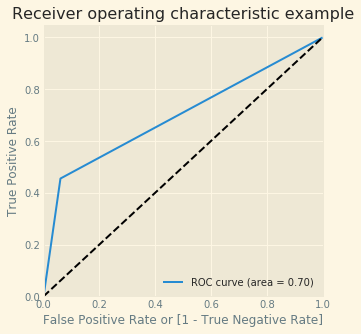

In [113]:
draw_roc(y_train_pred_final.Income, y_train_pred_final.Income_Prob)

### AUC - 70 %